In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, let's load in the data, take a look at some of the variables, and see how many missing values there are.

In [2]:
os.chdir('C:/Learning/ML/springboard_projects/interview_takehome_challenge/ultimate_challenge')
with open('ultimate_data_challenge.json') as json_file:
    data = json.load(json_file)
    
data = pd.DataFrame(data)
print(data.head())


print('Number of missing values for each variable:\n', data.isna().sum())
#we are missing a small number of records avg_raing_by_driver, many acg_rating_of_driver, some phone

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

We can look at the distribution of user activity. It turns out 37% of users remain active after six months, while the remainder no longer stay active. Looking at how long users stay active, it appears that most users only stay active for a day or two. After that, the distribution is relatively flat until around 100+ days of activity, spiking at five months of activity, which is around the amount most active users in the dataset have.

In [3]:
# user is still considered active if they have a trip in the month of June
data['active_flag'] = False
data.loc[data.last_trip_date > '2014-06-01', 'active_flag'] = True
vc = data.active_flag.value_counts()
print("Percentage of users still active: ", vc[1] / (vc[0] + vc[1]))

Percentage of users still active:  0.3662


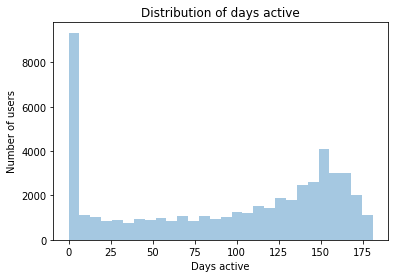

In [4]:
# create a variable for # of days in system
data.signup_date.value_counts()
data.last_trip_date.value_counts()
data.signup_date = pd.DatetimeIndex(data.signup_date)
data.last_trip_date = pd.DatetimeIndex(data.last_trip_date)

data['active_duration'] = ((data.signup_date - data.last_trip_date).abs() / np.timedelta64(1, 'D')).astype(int)

plt.figure()
sns.distplot(data['active_duration'], hist=True, kde=False)
plt.xlabel("Days active")
plt.ylabel("Number of users")
plt.title("Distribution of days active")
plt.show()


We'll start exploring what variables take on different values for active and non-active users. To do this, we'll write a function making it quick and easy to visualize how different categorical variables vary between active and non-active users. Three variables in particular reveal valuable findings; users in King's Landing stay active the most, Ultimate Black users stay active more than those who don't use Ultimate Black, and almost no Android users remain active. 

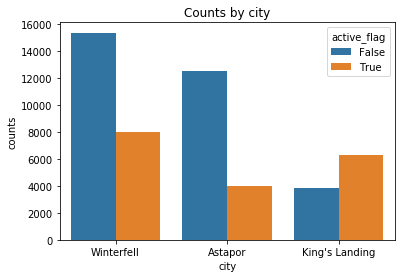

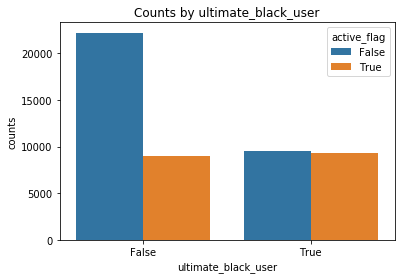

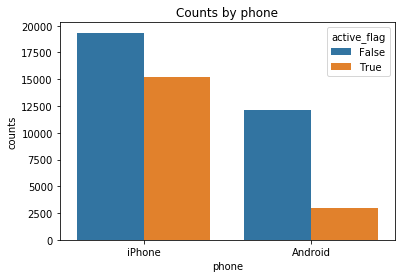

In [5]:
#doing some groupby active_flag to identify major differences in variables
grouped = data.groupby('active_flag')
def visualize_comparison(var_name):
    df = grouped[var_name].value_counts().reset_index(name='counts')
    plt.figure()
    sns.barplot(x=var_name, y='counts', hue='active_flag', data=df)
    plt.title(str("Counts by " + var_name))
    plt.show()
    

visualize_comparison('city')    
visualize_comparison('ultimate_black_user')
visualize_comparison('phone')

To visulaize the difference between active and non-active users for continuous variables, we can use KDE (kernel density estimate) plots. Two particularly interesting variables are surge_pct and weekday_pct. There is a clear pattern where users who are still active tend to have very low values for surge_pct, while non-active users had higher values. 

For another variable, weekday_pct, there's an interesting difference of distributions. Non-active users tend to have either values of either 0 or 100, while active users more commonly take on values between the two extremes.

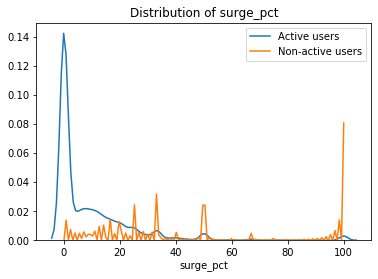

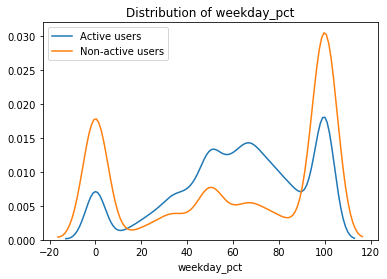

In [6]:
def visualize_continuous(var_name, plot_hist=True):
    plt.figure()
    sns.distplot(data.loc[data.active_flag == True, var_name], hist=plot_hist, kde=not plot_hist, label="Active users")
    sns.distplot(data.loc[data.active_flag == False, var_name], hist=plot_hist, kde=not plot_hist, label="Non-active users")
    plt.title(str("Distribution of " + var_name))
    plt.show()
    
visualize_continuous('surge_pct', False)
visualize_continuous('weekday_pct', False)


Next, we'll develop a model to predict if a given user is still active or not. 

There is a considerable amount of data preparation needed for this. Categorical columns must be encoded as numbers. Missing values need to be handled; for categorical variables we'll create a new category 'missing', while for continuous variables we'll impute missing values with the mean of that variable. To help improve model performance, we'll standardize all numeric variables, transforming them to have mean 0 and standard deviation 1. We'll split the data into training and testing sets, and in the training set, upsample data from the less common class of active users so that our training data has balanced classes. 

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

#split the data into categorical and continuous features
categorical_columns = ['city', 'phone', 'ultimate_black_user', 'active_flag']
continuous_columns = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_rating_by_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist']

#handle missing categorical features
categorical_data = data[categorical_columns]
categorical_data.loc[categorical_data['phone'].isna(), 'phone'] = 'Missing'

#encode cateogrical features
ohe = ce.OneHotEncoder()
categorical_data = ohe.fit_transform(categorical_data)


#handle missing continuous features
continuous_data = data[continuous_columns]
imp = SimpleImputer()
imp_data = imp.fit_transform(continuous_data)
continuous_data = pd.DataFrame(imp_data, columns=continuous_data.columns)

#scale continuous features
scaler = StandardScaler()
scaled = scaler.fit_transform(continuous_data)
continuous_data = pd.DataFrame(data=scaled, columns=continuous_data.columns)
prepared_data = pd.concat([continuous_data, categorical_data], axis=1)

#split the data into train and test
X_train, X_test = train_test_split(prepared_data, train_size = .75)
#sample from the less common positive class so that we have balanced classes
upsample_amount = X_train.active_flag.value_counts()[0] - X_train.active_flag.value_counts()[1]
upsample_data = X_train[X_train.active_flag == True].sample(n=upsample_amount, random_state=42, replace=True)
X_train = X_train.append(upsample_data)
y_train = X_train.active_flag
y_test = X_test.active_flag
X_train = X_train.drop(labels='active_flag', axis=1)
X_test = X_test.drop(labels='active_flag', axis=1)
                        


C:\Users\bwulz\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Our question is one of classification, determining if a given user is either still active or no longer active. To model this, we'll use a random forest classifier, an ensemble method well suited to these types of tasks. 

In [8]:
#use a random forest classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print("Model accuracy on test data:", accuracy_score(y_test, pred))
print("Confusion matrix:")
cm = confusion_matrix(y_test, pred)
print(cm)
print("Classification report:")
cr = classification_report(y_test, pred)
print(cr)


C:\Users\bwulz\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model accuracy on test data: 0.75136
Confusion matrix:
[[6458 1487]
 [1621 2934]]
Classification report:
              precision    recall  f1-score   support

       False       0.80      0.81      0.81      7945
        True       0.66      0.64      0.65      4555

    accuracy                           0.75     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.75      0.75      0.75     12500



To evaluate the model performance, we'll look at a few different metrics. The accuracy gives us a general idea of how well our model is doing, getting the prediction correct about 75% of the time. By looking at the confusion matrix, we can see that the model does much better at predicting non-active users than active users. This can be further detailed in the classification report, which helps quantify our performance with precision, recall, and the f1-score across the two classes. 

From the work we've done, there's a few lessons we can take away to recommend how Ultimate might be able to improve retention. Users in King's Landing and iPhone users both have better retention than other cities and phones, so targeting advertisements on IOS and in King's Landing might be most profitable. Users who use Ultimate Black have the highest retention rates, so a special first-time deal on this service might help improve retention. Riders who often pay surge pricing tend not to stay active, so it may be worth considering balacing tradeoff between surge pricing and long-term retention. 